# Homework 4
### Titanic: Machine Learning from Disaster [Kaggle Competition]
##### Erik Webb

Welcome! Here we visit the tragic tale of the RMS Titanic, a British passenger ship that sank in 1912 after colliding with an iceberg during its maiden voyage. Of the estimated 2,224 passengers on board, more than 1,500 died. ([Source](https://en.wikipedia.org/wiki/RMS_Titanic))

Much has been said and written about this epic tragedy. The dataset we will be using has been analyzed, inspected, and scrutinized many, _many_ times. It contains information about the characteristics of passengers who survived the crash and subsequent sinking and those that did not. Although it's easy to forget, the individuals represented in this dataset were real people, with real lives and real family members who mourned their loss. 

Even though this classification problem has been attempted [many times](https://www.kaggle.com/c/titanic/leaderboard) (solved for that matter), it still provides an important opportunity for growth for budding data scientists. It seems to almost have become a rite-of-passage in the world of machine learning. With that brief introduction, let's buckle up and get started! 

Helpful Links:
- https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
- https://www.kaggle.com/ash316/eda-to-prediction-dietanic

In [1]:
# An image of the Titanic for inspiration 
from IPython.display import Image
Image(url= "https://upload.wikimedia.org/wikipedia/commons/d/db/Titanic-Cobh-Harbour-1912.JPG")

In [2]:
# Core Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
%matplotlib inline

# ML Packages
from sklearn.linear_model import SGDRegressor, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Other Packages
import missingno as msno

In [3]:
# Bring in the data
train_location = "/Users/erikgregorywebb/Documents/Python/data/Titanic-Machine-Learning-from-Disaster/train.csv"
test_location = "/Users/erikgregorywebb/Documents/Python/data/Titanic-Machine-Learning-from-Disaster/test.csv"

train = pd.read_csv(train_location)
test = pd.read_csv(test_location)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1. Data Cleaning 

Let's start cleaning the data. Are there missing values?

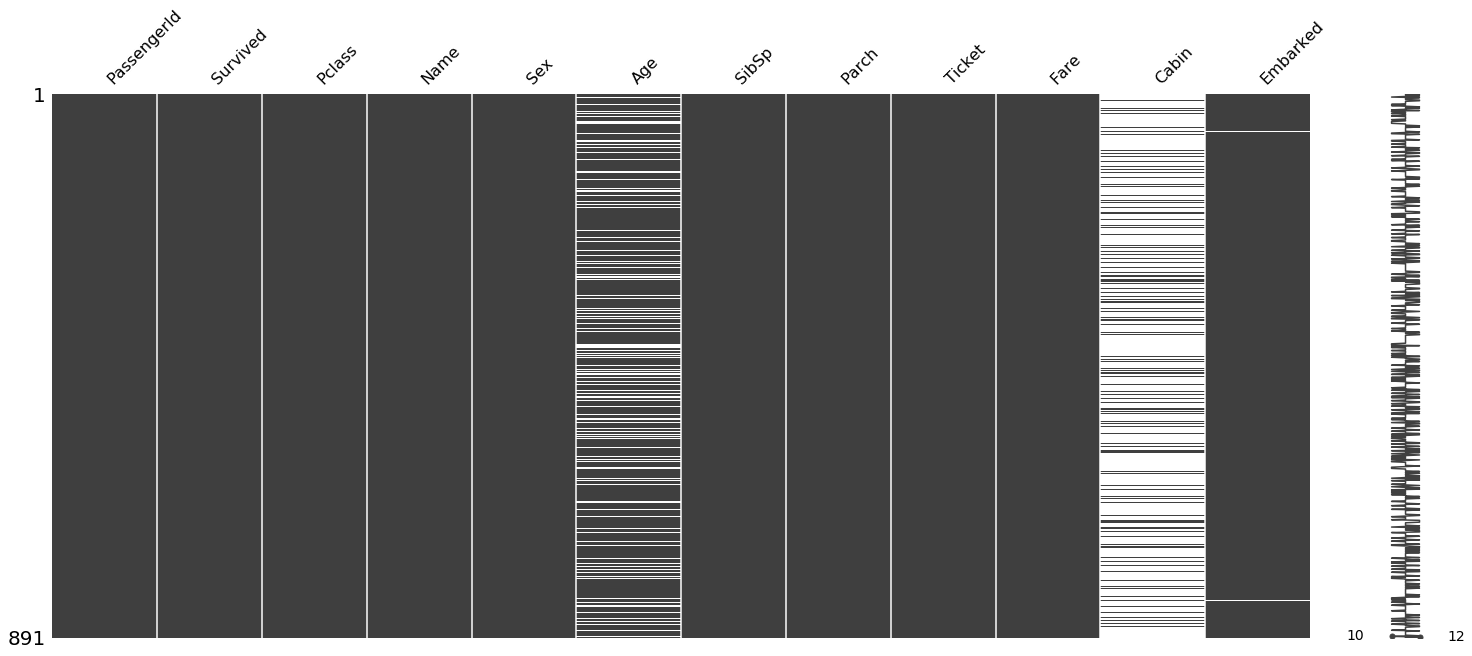

In [5]:
msno.matrix(train)

It looks like there are many missing 'Cabin' values, some missing 'Age' values, and only two missing 'Embarked' values. Let's get more specific:

In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Are these values missing at random? Or is there something systematic about the missing values? Here's one attempt to find out. 

Below we separate the rows that contain missing values from those that do not, calculate a correlation matrix for each, and then find a 'difference' correlation matrix by subtracting the correlation matrices from each other. The idea is that large differences would hint that values are missing in some systematic way and not randomly.

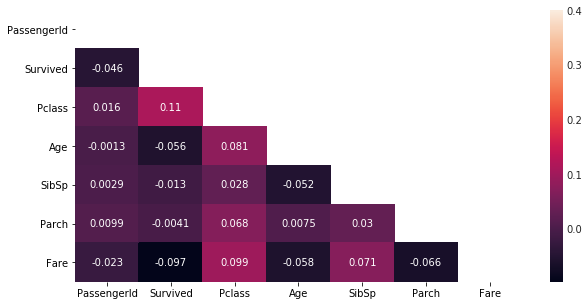

In [7]:
# Seperate rows that contain missing values from those that dn't
missing = train[pd.isnull(train).any(axis=1)]
not_missing = train[pd.notnull(train).any(axis=1)]

# Create a 'difference' correlation matrix
diff = missing.corr() - not_missing.corr()

# Display a heatmap to highlight the differences
f, ax = plt.subplots(figsize=(10, 5))
mask = np.zeros_like(diff)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    x = sns.heatmap(diff, mask=mask, annot = True, vmax=.4, square = False, ax = ax)

The largest difference is 0.11. This isn't a catch-all way to check for this kind of issue, but it's one way. Let's continue with the analysis, having some confidence that missing values occur roughly randomly.

With that said, let's start with age. We'll fill in the missing values with the average value. We'll drop the 'Cabin' feature (since over 77% of values are missing) and fill in the two missing 'Embarked' values with the mode. 

In [8]:
# Fill in the missing values of Age with the mean
train['Age'] = train['Age'].fillna(train['Age'].mean())

# Fill in two missing values of Embarked with the mode
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

# Drop the 'Cabin' feature
train = train.drop(['Cabin'], axis = 1)

We'll confirm there are no additional missing values:

In [9]:
# Should return 'False'
train.isnull().any().any()

False

With the missing values taken care of, let's address the data types of the features. What do I mean by this? For example, 'Survived' and 'Pclass' are really a categorical variables, but they are currently being treated as 'integer' types:

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


Let's fix that by changing them to a dtype of 'Category'.

In [11]:
train['Survived'] = train['Survived'].astype('category')
train['Pclass'] = train['Pclass'].astype('category')

Before we finish the data cleaning step, let's try our hand at feature engineering. We won't do anything too crazy though. As we'll explore in greater below, 'SibSp' represents the number of siblings and spouses aboard the Titanic and 'Parch' represents the number of parents and children aboard the Titanic. Let's create a single variable called 'FamSize' which represents the total number of family members a given passenger had aboard the ship.

In [12]:
# Feature engineer a 'FamSize' variable
train['FamSize'] = train['SibSp'] + train['Parch']

### 2. Data Exploration & Visualization 

With the data cleaned, let's develop a better understanding of the features, especially the relationship between our features and the target variable, 'Survived'. 

##### Survived
Let's begin with the basics. How many passengers in our dataset survived? How many died?

In [13]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [14]:
print(round(342/(549+342),2)*100, "% of the passengers in the dataset survived.")

38.0 % of the passengers in the dataset survived.


Survival is clearly binary variable: it only takes on two values. For the sake of prediction, we want to know what qualities or characteristics of passengers are related to the probability of survival. 

##### Ticket Class
Let's start with Ticket Class ('Pclass'), a proxy variable for socio-economic status. 

In [15]:
# Cross tab is an way to get a frequency tables
pd.crosstab(train['Survived'], train.Pclass)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


Back-of-napkin calculations quickly reveal that about 63% of upper-class passengers survived  compared to 24% of lower-class passengers! This will clearly be an important feature in predicting survival.

##### Sex

What about sex? [Wikipedia](https://en.wikipedia.org/wiki/Women_and_children_first) reports the following: "Women and children first" is a code of conduct dating from 1852, whereby the lives of women and children were to be saved first in a life-threatening situation, typically abandoning ship, when survival resources such as lifeboats were limited.

In other words, we'd have a strong hunch that sex is a strong predicted of survival. What does the data say?

Text(0.5,1,'Survived: Male vs. Female')

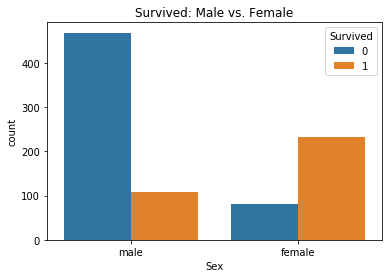

In [16]:
ax = sns.countplot('Sex', hue='Survived',data = train)
ax.set_title('Survived: Male vs. Female')

Just as we expected! Sex is a strong predictor of survival. Being a female generally meant a higher probability of survival. This may have been related to the fact that the vast majority of the crew was male, and many did not survive. 

##### Age
Let's keep moving and examine age.

Text(0.5,1,'Survived: Age')

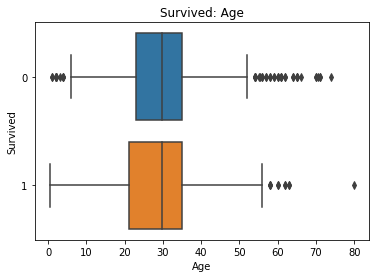

In [17]:
ax = sns.boxplot(x = 'Age', y = 'Survived', data = train)
ax.set_title('Survived: Age')

Interesting. Age doesn't seem to have been as important in determining survival. Note the 80+ year-old outlier who survived! 

##### Family Size

Rather than examine the 'SibSp' and 'Parch' features separately, let's examine our engineered feature 'FamSize'.

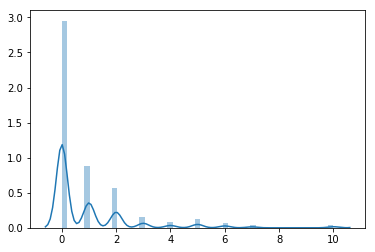

In [18]:
# Distribution of family size for those aboard the Titanic
sns.distplot(train.FamSize.values)

In [19]:
train['FamSize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamSize, dtype: int64

Most people (about 60% in this sample) cruised on the Titanic 'alone', or without direct family members. How did this impact their chance of survival? 

Text(0.5,1,'Survived: Family Size')

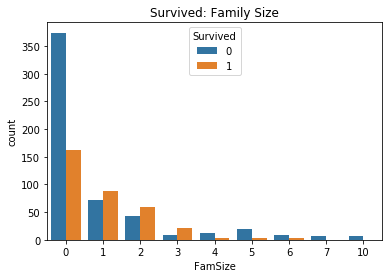

In [20]:
ax = sns.countplot('FamSize', hue='Survived',data = train)
ax.set_title('Survived: Family Size')

Visually, it appears that a larger proportion of those without any family members did not survive compared to those with one or more family members. This is interesting because I would have hypothesized the opposite to be true: Those without family members to care for would have had a _better_ chance to quickly exit the ship. Either way, this should prove to be a valuable feature in predicting survival.

##### Port of Embarkation

There were three possible ports of embarkation: Cherbourg, Queenstown, and Southampton.

Southampton was on the south coast of England and was the location of the Titanic’s departure. With 80% of the ships's crew from Southampton, the loss of life was felt here prehaps more than anywhere else. ([Source](http://www.articlesfactory.com/articles/other/the-roles-of-belfast-southampton-cherbourg-queenstown-and-new-york-in-the-titanic.html)) Cherbourg, a city in France, had a small port and was the second stop. Finally, Queenstown is on the South Coast of Southern Ireland and was the last passenger pick-up of the Titanic. 123 peopele joined the liner there for the onward journey. ([Source](http://www.articlesfactory.com/articles/other/the-roles-of-belfast-southampton-cherbourg-queenstown-and-new-york-in-the-titanic.html))

In [21]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5,1,'Survived: Family Size')

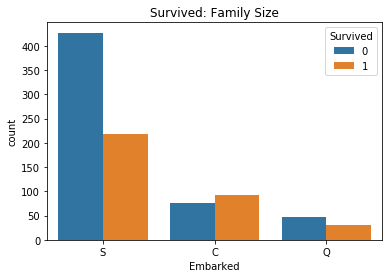

In [22]:
ax = sns.countplot('Embarked', hue='Survived',data = train)
ax.set_title('Survived: Family Size')

It looks like most passengers (in this sample) embarked from Southampton but passengers from Cherbourg had the greatest relative chance of survival. Are the French just luckier than the English or Irish? 

Great! We've completed a basic exploration of the relationship between our features and the target variable. Before proceeding to the model phase, let's remove the 'PassengerId', 'Name', and 'Ticket' features. Although these features contain potentially contain valuable information (titles such as Dr., Mrs., Mr., etc.), let's start modeling and then check if we can improve accuracy later on through additional feature engineering if time permits.

In [23]:
# Drop the PassengerID', 'Name', and 'Ticket' features
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)

We're left with 8 features: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, and FamSize. Let's start modeling!

### 3. Model Fitting & Evaluation

But before we get _too_ excited, let's do a few final data transformations:
1. Create a 'target' variable and drop 'Survived' from the training set
2. Apply the same transformation made to our training set to our test set 
3. Create dummy variables 
4. Scale the data

In [24]:
# 1. Create a 'target' variable and drop 'Survived' from the training set
target = train['Survived']
train = train.drop(['Survived'], axis = 1)

In [25]:
# 2. Apply the same transformation made to our training set to our test set

# Fill in the missing values of Age with the mean
test['Age'] = test['Age'].fillna(train['Age'].mean())

# Fill in two missing values of Embarked with the mode
test['Embarked'] = test['Embarked'].fillna(train['Embarked'].mode()[0])

# Drop the 'Cabin', 'PassengerID', 'Name', and 'Ticket' features
test = test.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis = 1)

# Fill in the one missing value of Fare with the mean
test['Fare'] = test['Fare'].fillna(train['Fare'].mean())

test['Pclass'] = test['Pclass'].astype('category')
test['FamSize'] = test['SibSp'] + test['Parch']

In [26]:
# 3. Create dummy variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [27]:
# 4. Scale the data
scaler = StandardScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

scaler.fit(test)
scaled_test = scaler.transform(test)

Let's make sure the train and test datasets have the correct dimensions. 

In [28]:
print("Train Dimensions:", scaled_train.shape, "\nTest Dimensions:", scaled_test.shape)

Train Dimensions: (891, 13) 
Test Dimensions: (418, 13)


Alright! Now we're ready to do some modeling. We'll try the following models:
1. Logistic Classifier
2. K-Nearest Neighbors
3. Naive_Bayes
4. SVM
5. Decision Tree
6. Random Rorest
7. Gradient Boosting

In [29]:
# Split training dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(scaled_train, target, test_size=0.2, random_state=42)

In order to evaluate the models, I built the following two functions, largly adapted from [this](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_5_Logistic_Regression_and_Evaluation.ipynb) notebook.

The first function, evaluation_metrics, returns the accuracy, precision, recall, and f1 metrics for both the train and test set. The second function, precision_recall_curves, creates a plot that helps us determine if the probabilities generated by a given model seem to correlate with the classes.

In [30]:
# This image is a good, quick reminder of how each of these metrics are calculated
Image(url= "https://www.safaribooksonline.com/library/view/python-data-analysis/9781785282287/graphics/B04223_10_02.jpg")

In [31]:
def evaluation_metrics(y_train, y_test, train_predictions, test_predictions):
    rounding = 2
    print('Accuracy:')
    print("  Train: {}".format(round(accuracy_score(y_train, train_predictions),rounding)), "  Test: {}".format(round(accuracy_score(y_test, test_predictions),rounding)))

    print('Precision:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_train, train_predictions)[0][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[0][0],rounding)))

    print('Recall:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_train, train_predictions)[1][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[1][0],rounding)))

    print('F1:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_train, train_predictions)[2][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[2][0],rounding)))

In [32]:
def precision_recall_curves(model, X, Y):
    train_prediction_probabilities = model.predict_proba(X)
    train_probs_for_actual_1 = [train_prediction_probabilities[i][1] for i, truth in enumerate(Y) if truth == 1]
    train_probs_for_actual_0 = [train_prediction_probabilities[i][1] for i, truth in enumerate(Y) if truth == 0]
    plt.hist(train_probs_for_actual_1, label='1')
    plt.hist(train_probs_for_actual_0, label='0')
    plt.legend(loc='upper left')
    plt.title("Precision Recall Curve")
    plt.xlabel("Probability")

##### 1. Logistic Classifier

Since we would like a probability (between 0 and 1) of survival to predict the classification, we begin with a logistic classifier.

The logistic classifier defines a cost function, calculates gradients (the logistic cost function is convex and has a single global minimum) and then uses a gradient descent algorithm to determine coefficient values that minimize the defined cost function. Enough talk, let's try it out! 

In [33]:
# Fit a model with the default penalty, l2
lr = linear_model.LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
lr_train_predictions = lr.predict(X_train)
lr_test_predictions = lr.predict(X_test)

In [34]:
evaluation_metrics(y_train, y_test, lr_train_predictions, lr_test_predictions)

Accuracy:
  Train: 0.81   Test: 0.8
Precision:
  Train: 0.82   Test: 0.81
Recall:
  Train: 0.88   Test: 0.86
F1:
  Train: 0.85   Test: 0.83


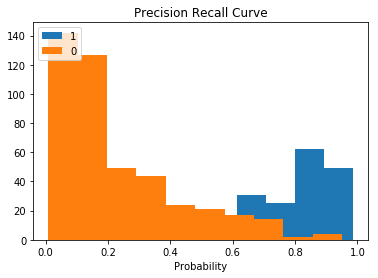

In [35]:
precision_recall_curves(lr, X_train, y_train)

Sweetness! There's our first model. It had 80% accuracy in the test set. Let's take a look at the coefficients:  

Text(0.5,1,'Coefficients: Logistic Classifier')

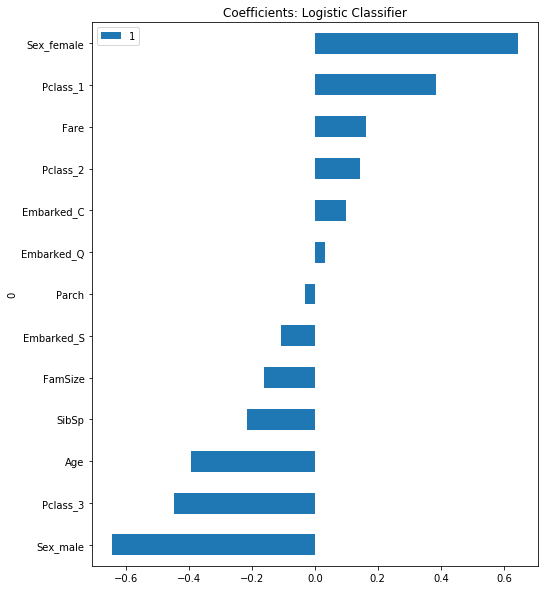

In [36]:
# Create a dataframe with coefficient values
df = pd.DataFrame(sorted(list(zip(train.columns, lr.coef_[0])), key=lambda x: x[1]))
df.index = df[0]
df = df.drop([0], axis = 1)

# Create a bar chart with the coefficients
plt.rcParams['figure.figsize'] = (8.0, 10.0)
df.plot(kind = "barh")
plt.title("Coefficients: Logistic Classifier")

Very cool! The coefficient estimates align well with the data exploration conclusions we previously discussed. In this model, sex is most important determinate of survival, following my passenger class. Let's try another model.

##### 2. K-Nearest Neighbors

K-nearest neighbors relies on the idea of the "quack" test: If it looks like a duck, smells like a duck, and acts like a duck, it probably is a duck! K refers to how many neighbors to consider when classifying a new data point.

As a reminder, here are the steps of k-nearest neighbors:
1. Define k (where a high value of k has more bias, and a low k has more variance)
2. Define a distance metric (usually Euclidean distance)
3. For a new data point, find the k nearest training points and combine the classes in some way, usually voting, to get a predicted class.

In [37]:
param_dist = {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 'p': [1, 2, 3]}
model = KNeighborsClassifier()
knn = GridSearchCV(model, param_grid = param_dist, scoring='f1')
knn.fit(X_train, y_train)
knn_train_predictions = knn.predict(X_train)
knn_test_predictions = knn.predict(X_test)
print("Best Params: {}".format(knn.best_params_))

Best Params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [38]:
evaluation_metrics(y_train, y_test, knn_train_predictions, knn_test_predictions)

Accuracy:
  Train: 0.98   Test: 0.8
Precision:
  Train: 0.97   Test: 0.82
Recall:
  Train: 1.0   Test: 0.85
F1:
  Train: 0.98   Test: 0.83


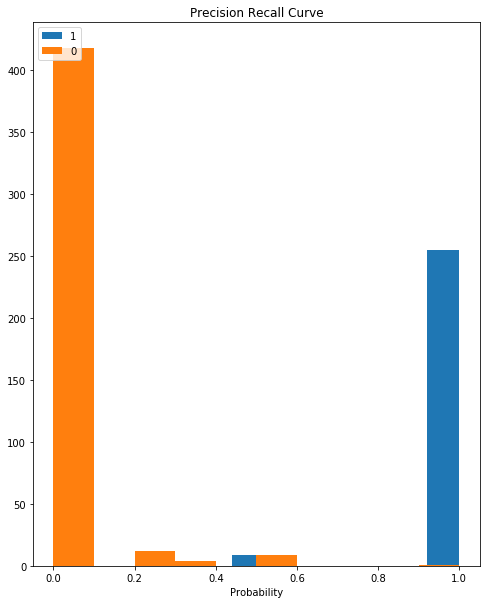

In [39]:
precision_recall_curves(knn, X_train, y_train)

It looks like our k-nearest neighbors model predicts better than logistic regression in the training set, but about the same in the test set. Up until now, we've only used F1 as our evaluation metric. Let's try recall!

In [40]:
model = KNeighborsClassifier()
knnr = GridSearchCV(model, param_grid = param_dist, scoring='recall')
knnr.fit(X_train, y_train)
knn_train_predictions = knnr.predict(X_train)
knn_test_predictions = knnr.predict(X_test)
print("Best Params: {}".format(knnr.best_params_))

Best Params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [41]:
evaluation_metrics(y_train, y_test, knn_train_predictions, knn_test_predictions)

Accuracy:
  Train: 0.98   Test: 0.8
Precision:
  Train: 0.97   Test: 0.82
Recall:
  Train: 1.0   Test: 0.85
F1:
  Train: 0.98   Test: 0.83


Cross validation returned the same 'best' parameters using F1 and recall, so we'll stick with F1. 

##### 3. Naive_Bayes

Bayes theorem allows us to go from a prior and sampling distribution to a posterior distribution, where the sampling distribution is the probability of seeing our data given our parameters. We want the posterior, or the probability of our parameters given our data and are typically given data and want to figure out what parameters are most likely given our data.

With that background about Bayes Theorem in mind, Naive Bayes basically calculates the probability of one of our classes given our data. The prior is easy to calculate (its just the probability of being in that class as seen in the training data). In this case, we'll use the Gaussian distribution as our likelihood.

In [42]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_train_predictions = nb.predict(X_train)
nb_test_predictions = nb.predict(X_test)

In [43]:
evaluation_metrics(y_train, y_test, nb_train_predictions, nb_test_predictions)

Accuracy:
  Train: 0.79   Test: 0.77
Precision:
  Train: 0.84   Test: 0.83
Recall:
  Train: 0.83   Test: 0.77
F1:
  Train: 0.83   Test: 0.8


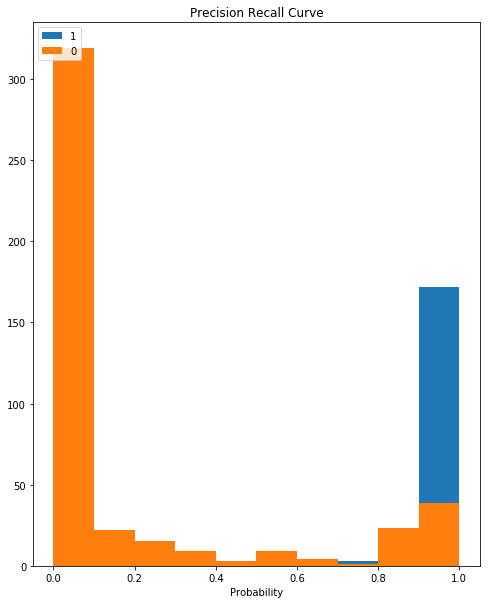

In [44]:
precision_recall_curves(nb, X_train, y_train)

This model appeared to perform slightly _worse_ than the previous two models. In the precision recall chart above it also seems strange that observations with a very high probability (close to 1) are being classified as 0. 

##### 4. SVM

A little background: SVM chooses a hyperplane to separate the classes, implying that we only care about data points from each class that are closest to the separating hyperplane. These points are called support vectors. Hence the name of the model, support vector machine. With a soft-margin classifier, the trick is finding a balance between a max-margin classifier and limiting the number of margin violations, which are the data points that fall on the wrong side of the hyperplane.


In [45]:
param_dist = {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 'degree': [1,2,3]}
model = SVC()
svm = GridSearchCV(model, param_grid = param_dist, scoring='f1')
svm.fit(X_train, y_train)
svm_train_predictions = svm.predict(X_train)
svm_test_predictions = svm.predict(X_test)
print("Best Params: {}".format(svm.best_params_))

Best Params: {'C': 0.2, 'degree': 1, 'kernel': 'rbf'}


In [46]:
evaluation_metrics(y_train, y_test, svm_train_predictions, svm_test_predictions)

Accuracy:
  Train: 0.82   Test: 0.8
Precision:
  Train: 0.82   Test: 0.81
Recall:
  Train: 0.91   Test: 0.88
F1:
  Train: 0.86   Test: 0.84


Meh, seemed like SVM performed roughly the same (if not a little worse) than other models we've implemented. Let's move on to a decision tree model.

##### 5. Decision Tree

One of advantages of decision tree models is that they handle categorical variables AND missing data well. Here we'll fit and compare two models: one with the cleaned data and one with the original data which contains missing values.

In [47]:
# Model with CLEAENED data
param_dist = {"criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dt = GridSearchCV(model, param_grid = param_dist, scoring='f1')
dt.fit(X_train, y_train)
dt_train_predictions = dt.predict(X_train)
dt_test_predictions = dt.predict(X_test)
print("Best Params: {}".format(dt.best_params_))

Best Params: {'criterion': 'entropy'}


In [48]:
evaluation_metrics(y_train, y_test, dt_train_predictions, dt_test_predictions)

Accuracy:
  Train: 0.98   Test: 0.79
Precision:
  Train: 0.97   Test: 0.81
Recall:
  Train: 1.0   Test: 0.83
F1:
  Train: 0.98   Test: 0.82


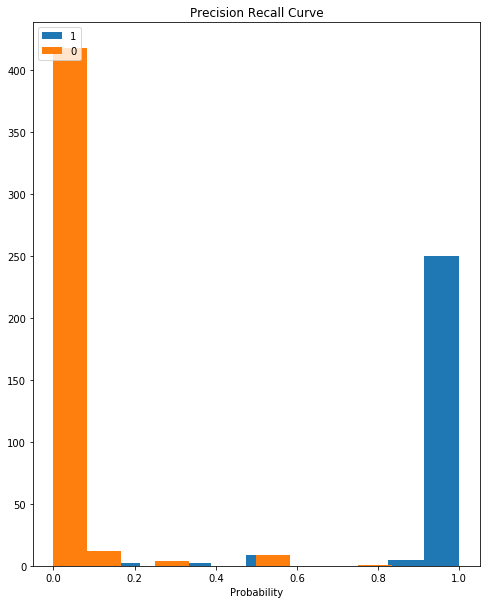

In [49]:
precision_recall_curves(dt, X_train, y_train)

In [50]:
# Bring in the ORIGINAL data and apply relevant transformations
train_dt = pd.read_csv(train_location)
test_dt = pd.read_csv(test_location)

scaler = StandardScaler()
scaler.fit(train)
scaled_train_dt = scaler.transform(train)

scaler.fit(test)
scaled_test_dt = scaler.transform(test)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(scaled_train_dt, target, test_size=0.2, random_state=42)

In [51]:
# Model with ORIGINAL data
param_dist = {"criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dto = GridSearchCV(model, param_grid = param_dist, scoring='f1')
dto.fit(X_train_dt, y_train_dt)
dto_train_predictions = dto.predict(X_train_dt)
dto_test_predictions = dto.predict(X_test_dt)

In [52]:
evaluation_metrics(y_train_dt, y_test_dt, dto_train_predictions, dto_test_predictions)

Accuracy:
  Train: 0.98   Test: 0.77
Precision:
  Train: 0.97   Test: 0.8
Recall:
  Train: 1.0   Test: 0.8
F1:
  Train: 0.98   Test: 0.8


Was there a difference? Not really. Precision in the test set increased by .01 and recall and F1 in the test set decreased by .01. Interesting! 

Let's move to a more powerful model, Random Forest!

##### 6. Random Forest

The fundamental idea of a random forest model is that combining weak learners (decision trees) can led to a strong learner (random forests). It is an ensemble model, meaning that a group of models are used together to make a prediction. The cost of doing so is the ability to interpret the model. Also, we would like each of the trees to be as varied as possible; if they are very correlated then we do not gain much.

In [53]:
param_dist = {"n_estimators": [500, 1000, 2500], "max_depth": [1, 3, 7, 10, 12, 15]}
model = RandomForestClassifier()
rf = GridSearchCV(model, param_grid = param_dist, scoring='f1')
rf.fit(X_train, y_train)
rf_train_predictions = rf.predict(X_train)
rf_test_predictions = rf.predict(X_test)
print("Best Params: {}".format(rf.best_params_))

Best Params: {'max_depth': 7, 'n_estimators': 500}


In [54]:
evaluation_metrics(y_train, y_test, rf_train_predictions, rf_test_predictions)

Accuracy:
  Train: 0.89   Test: 0.82
Precision:
  Train: 0.87   Test: 0.81
Recall:
  Train: 0.97   Test: 0.91
F1:
  Train: 0.92   Test: 0.86


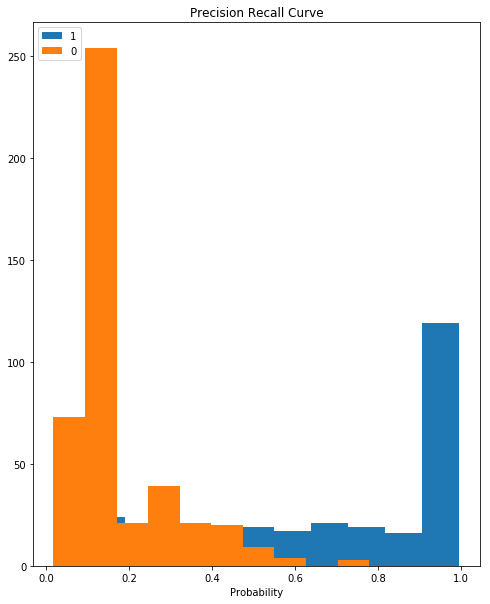

In [55]:
precision_recall_curves(rf, X_train, y_train)

Great! Let's check out the relative importance of the features used in this model. The code below was adapted straight from Tyler Folkman's [lecture notes](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_10_Random_Forest.ipynb). 

In [56]:
# Fit model using 'best' parameters from above
rff = RandomForestClassifier(n_estimators = 2500, max_depth = 7)
rff.fit(X_train, y_train)

# Determine feature importance
feature_imp = sorted(list(zip(train.columns, rff.feature_importances_)), key=lambda x: x[1], reverse=True)

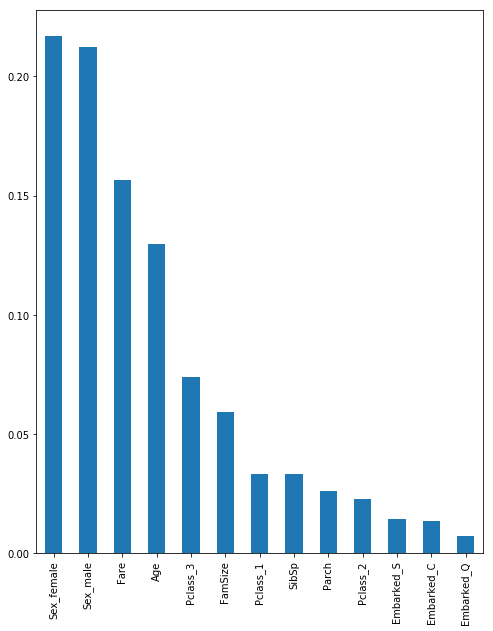

In [57]:
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

Looks somewhat similar to our feature importance bar chart for logistic classification. Again, the most important features is sex, but this model considers fare to be more important than passenger class.

##### 7. Gradient Boosting

Our final model! Boosting is an ensemble technique like random forests. With random forests, decision trees are trained independently and created independence by randomly sampling samples and features. Boosting trains multiple models sequentially where each each model tries to improve on the areas where the previous models performed poorly.

Here we'll use accuracy as the evaluation metric rather than F1.

In [58]:
param_dist = {"learning_rate": [.1, .01, .001], "n_estimators": [100, 1000, 5000], 'max_depth': [1, 2, 3]}
model = GradientBoostingClassifier()
gb = GridSearchCV(model, param_grid = param_dist, scoring='accuracy')
gb.fit(X_train, y_train)
gb_train_predictions = gb.predict(X_train)
gb_test_predictions = gb.predict(X_test)

In [59]:
evaluation_metrics(y_train, y_test, gb_train_predictions, gb_test_predictions)

Accuracy:
  Train: 0.84   Test: 0.8
Precision:
  Train: 0.85   Test: 0.81
Recall:
  Train: 0.91   Test: 0.88
F1:
  Train: 0.88   Test: 0.84


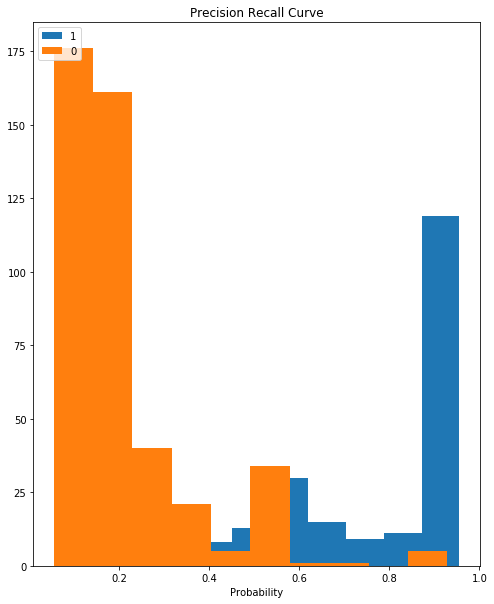

In [60]:
precision_recall_curves(gb, X_train, y_train)

### Conclusion

That's it! We've fit seven different models to predict the survival of passengers aboard the Titanic. We'll use these models to predict survival in the true testing set and then submit these predictions to Kaggle.

As of March 8, 2018, the highest rank I achieved was **4,071** out of 10,249, with a score of **.77990**.

What have we learned along the way? I noticed that more advanced models (random forest, gradient boosting) provided only a marginal boosts to predictive accuracy. Why is this important? Your ability to make good prediction is a function of both your data AND your models. You can't compensate for poor data with fancy modeling techniques. To further improve my score I would explore other types of feature engineering. 

Thanks for reading! 

In [85]:
# Export predictions to Kaggle

# Change working directory for exporting csv files
os.chdir("/Users/erikgregorywebb/Documents/Python/machine-learning/Submission/Titanic-Machine-Learning-from-Disaster")
test_submission = pd.read_csv(test_location)

# List of models used
models = [lr, knn, nb, svm, dt, rf, gb]
model_names = ["lr", "knn", "nb", "svm", "dt", "rf", "gb"]

# Iterate over each model, creating list of predictions and then export has csv
for i in range(0, len(models)):
    model = models[i]
    y_pred = model.predict(scaled_test)
    pred = pd.DataFrame({'PassengerId': list(test_submission['PassengerId'].astype(int)), 'Survived': list(y_pred)})
    filename = ('submission_{}.csv'.format(model_names[i]))
    pred.to_csv(filename, sep=',', index = False)